# **Project :** Evaluating Solutions to Ameliorate the Impact of Food Deserts in Brooklyn Using AI

## **Problem Statement :** Develop a Machine Learning model to classify food desert and non-food desert areas in Brooklyn (Kings County, New York)

## **1. Import Libraries**

In [1]:
#=================================================================
# For data manipulation, plotting, and miscellaneous
#=================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import calendar
from datetime import datetime

import pickle 
#===============================================================================================
import tensorflow as tf
tf.random.set_seed(3)
from tensorflow.math import confusion_matrix
#=================================================================
# From sklearn import required classes
#=================================================================
from sklearn import metrics
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz 
from IPython.display import display, Image
from graphviz import Source
from sklearn import tree

## **2. Load the Dataset and Perform Visualization**

### **2.1. Load the Dataset**

**Data Source :** https://github.com/omdena-chapter-brooklyn-food-desert/Data-Collection-and-Analysis/tree/main

In [2]:
#!git clone https://github.com/omdena-chapter-brooklyn-food-desert/Data-Collection-and-Analysis.git

In [3]:
df_preprocess = pd.read_csv('KingCounty_FoodDeserts_Iteration2_noclasses_2.csv')
df_preprocess.head(3)

,Unnamed: 0,STATEFP_x,COUNTYFP_x,TRACTCE,CensusTract,State,County,Urban,Pop2010,OHU2010,...,COUNTYFP_y,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,SNAP,TargetLabel
0,0,36,47,57800,36047057800,New York,Kings County,1,3176,1077,...,47.0,1400000US36047057800,3.604706e+10,578.0,CT,172233.0,0.0,POLYGON ((-73.95397799999999 40.60140099999999...,0.276615,1
1,1,36,47,37000,36047037000,New York,Kings County,1,4085,1566,...,47.0,1400000US36047037000,3.604704e+10,370.0,CT,336242.0,0.0,"POLYGON ((-73.96615 40.586669, -73.96564099999...",0.178423,0
2,2,36,47,19900,36047019900,New York,Kings County,1,2929,1476,...,47.0,1400000US36047019900,3.604702e+10,199.0,CT,188914.0,0.0,"POLYGON ((-73.96949 40.686288, -73.96749299999...",0.049125,0


In [4]:
df_preprocess.shape

(698, 330)

In [5]:
df_preprocess.columns

Index(['Unnamed: 0', 'STATEFP_x', 'COUNTYFP_x', 'TRACTCE', 'CensusTract',
       'State', 'County', 'Urban', 'Pop2010', 'OHU2010',
       ...
       'COUNTYFP_y', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER',
       'geometry', 'SNAP', 'TargetLabel'],
      dtype='object', length=330)

In [180]:
TRACTCE = df_preprocess['TRACTCE']
TRACTCE

0      57800
1      37000
2      19900
3      40000
4      98200
       ...  
693    39700
694    10200
695    82600
696    23400
697    75400
Name: TRACTCE, Length: 698, dtype: int64

In [6]:
features_req = ['DISADVANTAGE16_20', 'MEDFAMINC16_20', 'SNAP', 'PovertyRate','TractSNAP','TargetLabel']

### **2.2. Store Required Features in DF**

In [7]:
# copy required features
df = df_preprocess.loc[:, features_req]
df.head(3)

,DISADVANTAGE16_20,MEDFAMINC16_20,SNAP,PovertyRate,TractSNAP,TargetLabel
0,0.253815,87500,0.276615,21.6,278,1
1,0.214406,87813,0.178423,15.6,178,0
2,0.079001,161250,0.049125,12.4,183,0


In [8]:
df.rename(columns= {'DISADVANTAGE16_20':'Disadvantage', 'MEDFAMINC16_20':'Medfamilyincome'}, inplace=True)

In [9]:
df.head(3)

,Disadvantage,Medfamilyincome,SNAP,PovertyRate,TractSNAP,TargetLabel
0,0.253815,87500,0.276615,21.6,278,1
1,0.214406,87813,0.178423,15.6,178,0
2,0.079001,161250,0.049125,12.4,183,0


In [10]:
df.shape

(698, 6)

In [11]:
n_labels=df['TargetLabel'].nunique()
n_labels

2

In [12]:
df['TargetLabel'].value_counts()

0    443
1    255
Name: TargetLabel, dtype: int64

## **3. Exploratory Data Aanalysis (EDA)**

**Features Description:**

* Disadvantage = mean of pfaminclt40k16_20, ppov16_20, and ppubas16_20
    * pfaminclt40k16_20 : Proportion of families with income less than $40,000
    * ppov16_20 : Proportion people w/ income in the past 12 months below poverty level
    * ppubas16_20 : Proportion of households with public assistance income or food stamps
     

* Medfamilyincome = Tract median family income
* SNAP = Proportion of households with public assistance income or food stamps
* PovertyRate = Poverty Rate'
* TractSNAP = Total count of housing units receiving SNAP benefits in tract
   

In [13]:
df.isna().sum()

Disadvantage       0
Medfamilyincome    0
SNAP               0
PovertyRate        0
TractSNAP          0
TargetLabel        0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Disadvantage     698 non-null    float64
 1   Medfamilyincome  698 non-null    int64  
 2   SNAP             698 non-null    float64
 3   PovertyRate      698 non-null    float64
 4   TractSNAP        698 non-null    int64  
 5   TargetLabel      698 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 32.8 KB


### **3.1. Univariate Analysis**

<AxesSubplot: ylabel='TargetLabel'>

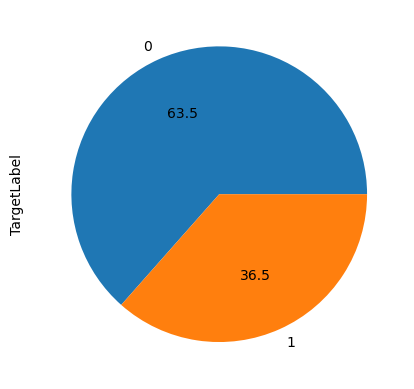

In [15]:
# Percentage of each target label 
df['TargetLabel'].value_counts().plot(kind='pie',autopct='%.1f')

<AxesSubplot: xlabel='TargetLabel', ylabel='count'>

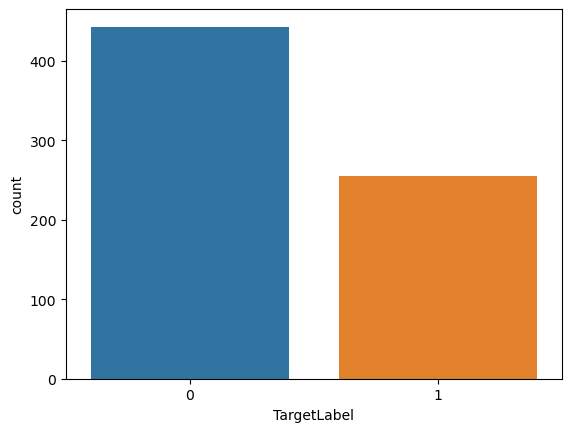

In [16]:
# Count plot
sns.countplot(data=df, x='TargetLabel')

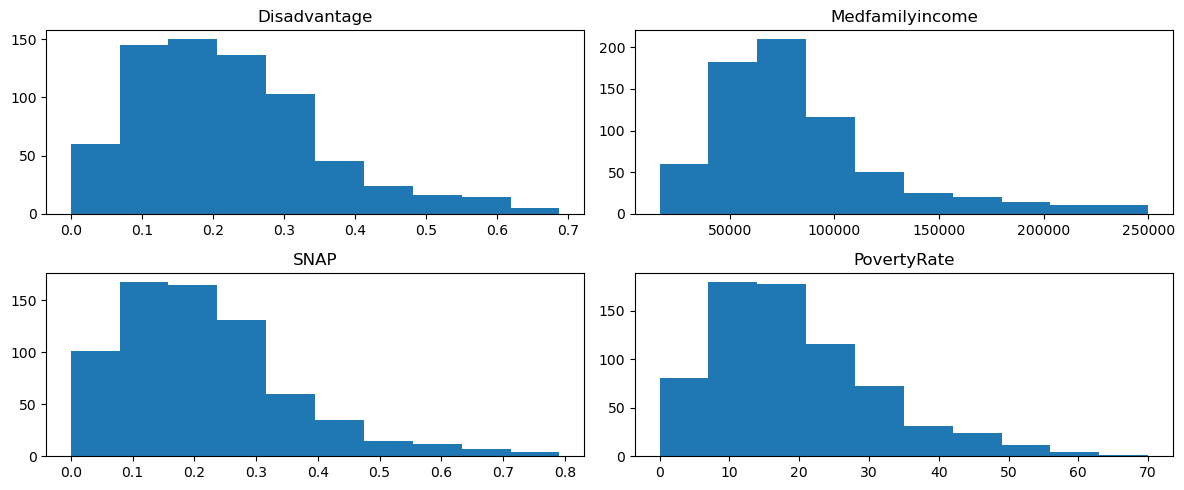

In [17]:
fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(2,2,1)
ax1.hist(df['Disadvantage'])
ax1.set_title('Disadvantage')

ax2 = fig.add_subplot(2,2,2)
ax2.hist(df['Medfamilyincome'])
ax2.set_title('Medfamilyincome')

ax3 = fig.add_subplot(2,2,3)
ax3.hist(df['SNAP'])
ax3.set_title('SNAP')

ax4 = fig.add_subplot(2,2,4)
ax4.hist(df['PovertyRate'])
ax4.set_title('PovertyRate')

plt.tight_layout()
plt.show()

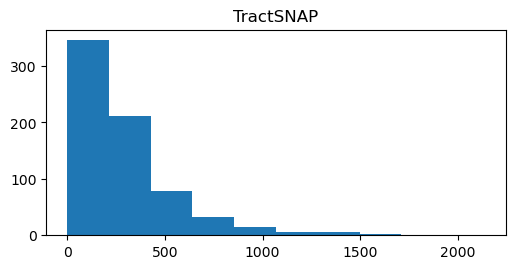

In [18]:
fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(2,2,1)
ax1.hist(df['TractSNAP'])
ax1.set_title('TractSNAP')

plt.tight_layout()
plt.show()

<AxesSubplot: >

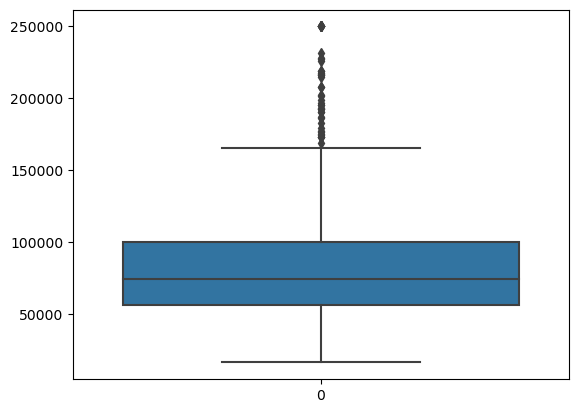

In [19]:
sns.boxplot(df['Medfamilyincome'])

### **3.2. Bivariate Analysis**

#### **3.2.1. Correlation matrix**

In [20]:
# create cocorrelation matrix
corr_df = df.corr().abs()
#corr_df = df.corr()
#mask = np.triu(np.ones_like(corr_df, dtype=bool))
#tri_df = corr_df.mask(mask)
#tri_df
corr_df

,Disadvantage,Medfamilyincome,SNAP,PovertyRate,TractSNAP,TargetLabel
Disadvantage,1.000000,0.757223,0.921736,0.870719,0.753653,0.781236
Medfamilyincome,0.757223,1.000000,0.677852,0.644375,0.537121,0.566810
SNAP,0.921736,0.677852,1.000000,0.776685,0.788666,0.724184
PovertyRate,0.870719,0.644375,0.776685,1.000000,0.665862,0.751412
TractSNAP,0.753653,0.537121,0.788666,0.665862,1.000000,0.569041
TargetLabel,0.781236,0.566810,0.724184,0.751412,0.569041,1.000000


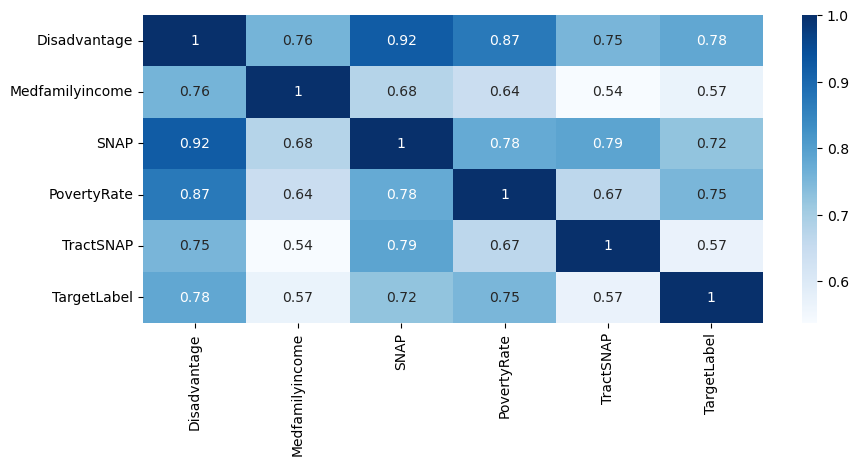

In [21]:
plt.figure(figsize=(10, 4))
sns.heatmap(corr_df, annot=True, cmap='Blues')
plt.show()

**Observations:**

**1) 'Disadvantage' feature is having high Correlation (0.92) with 'SNAP' feature, moreover it is dependent on 3 other variables as per NaNDA dataset hence it is dropped.**

In [22]:
df = df.drop(columns=['Disadvantage'])
df.shape

(698, 5)

In [23]:
df.head(3)

,Medfamilyincome,SNAP,PovertyRate,TractSNAP,TargetLabel
0,87500,0.276615,21.6,278,1
1,87813,0.178423,15.6,178,0
2,161250,0.049125,12.4,183,0


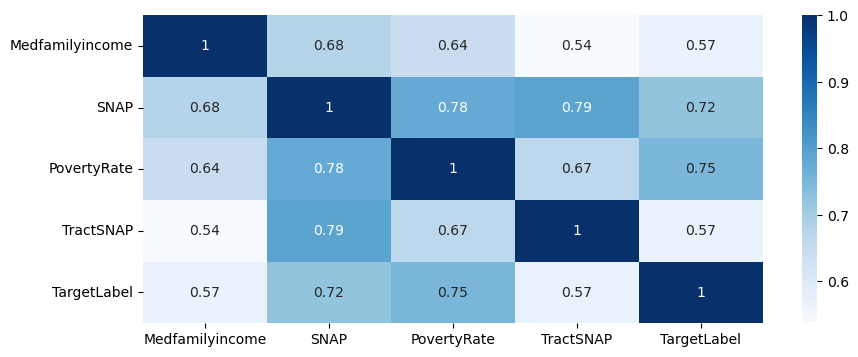

In [24]:
corr_df = df.corr().abs()
plt.figure(figsize=(10, 4))
sns.heatmap(corr_df, annot=True, cmap='Blues')
plt.show()

#### **3.2.2. Pair Plots**

<Figure size 800x400 with 0 Axes>

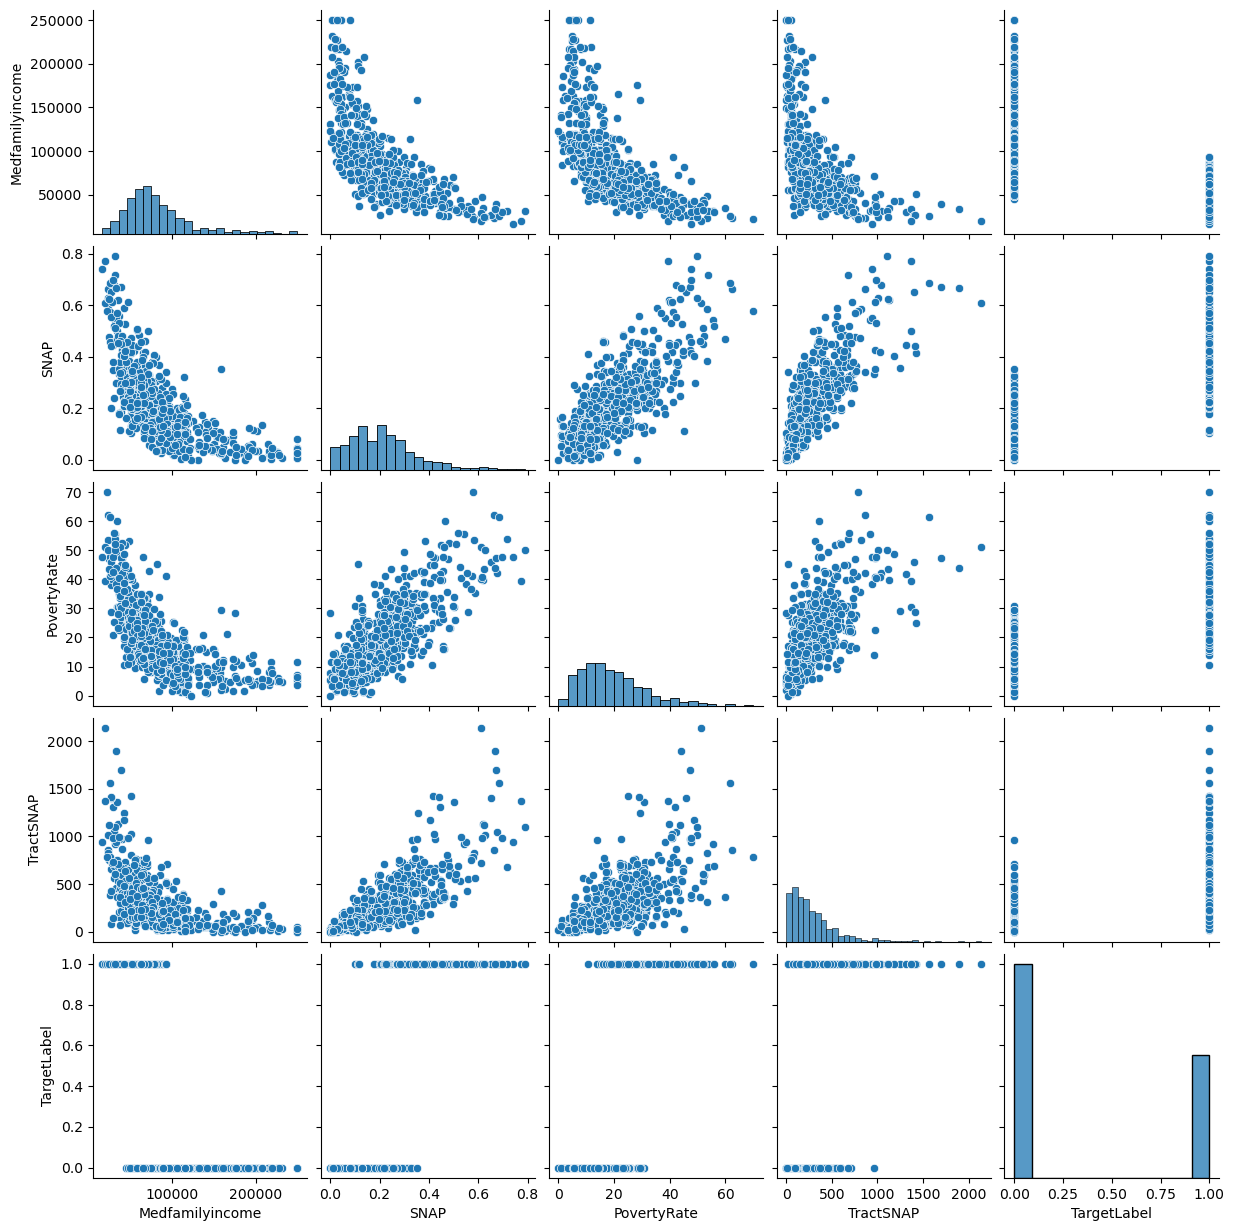

In [25]:
plt.figure(figsize=(8,4))
sns.pairplot(df)

In [26]:
df.to_csv('df.csv')  # saving for reference

### **3.3. Split the data into features (X) and target (y)**

In [27]:
X = df.drop(['TargetLabel'], axis=1)
y = df['TargetLabel']

In [28]:
X.head(3)

,Medfamilyincome,SNAP,PovertyRate,TractSNAP
0,87500,0.276615,21.6,278
1,87813,0.178423,15.6,178
2,161250,0.049125,12.4,183


In [29]:
y.head()

0    1
1    0
2    0
3    0
4    1
Name: TargetLabel, dtype: int64

In [30]:
y.value_counts()

0    443
1    255
Name: TargetLabel, dtype: int64

In [31]:
# Split the data into training and test sets
# parameter 'stratify' ensures the training and test subsets that have the same proportions of class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3, stratify = y )

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((558, 4), (140, 4), (558,), (140,))

In [33]:
X.shape, y.shape

((698, 4), (698,))

In [34]:
y_train.value_counts()

0    354
1    204
Name: TargetLabel, dtype: int64

In [35]:
y_test.value_counts()

0    89
1    51
Name: TargetLabel, dtype: int64

In [36]:
train_data = pd.concat([X_train,y_train], axis=1)
train_data.to_csv('Train_data.csv')   # for reference

In [37]:
test_data = pd.concat([X_test,y_test], axis=1)
test_data.to_csv('Test_data.csv')    # for reference

### **3.4. Normalizing the Input data**

**Since Random Forest is a Tree-based model, hence normalization of variables is optional**

## **4. Random Forest Model**

### **4.1. Create the Model**

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)








In [38]:
rfc = RandomForestClassifier(n_estimators=35, criterion='gini', max_depth=10, 
                             max_samples=0.75, max_features=0.5, oob_score=True,
                             random_state=3)
rfc.fit(X_train.values,y_train)

RandomForestClassifier(max_depth=10, max_features=0.5, max_samples=0.75,
                       n_estimators=35, oob_score=True, random_state=3)

In [39]:
train_acc = accuracy_score(y_train, rfc.predict(X_train))
test_acc = accuracy_score(y_test, rfc.predict(X_test))
print('Random Forest Training Accuracy:', round(train_acc,2))
print('Random Forest Testing Accuracy:', round(test_acc,2))  

Random Forest Training Accuracy: 1.0
Random Forest Testing Accuracy: 0.96


C:\Users\Srinivas\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Srinivas\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [40]:
rfc.oob_score_

0.9605734767025089

### **4.2. Cross validation score**

In [41]:
np.mean(cross_val_score(RandomForestClassifier(n_estimators=35,max_samples=0.75),X_train,y_train,cv=10,scoring='accuracy'))

0.9660064935064934

### **4.3. Hyper Parameter Tuning using GridSearchCV**

In [42]:
# Number of trees in random forest
n_estimators = [20,30,40,50,60,70,80,100]

# Number of features to consider at every split
max_features = [0.2,0.4,0.6,0.8,1.0]   # percentage of features

# Number of samples
max_samples = [0.5,0.75,1.0]   # percentage of samples to draw from training data to train each base estimator.

# Maximum number of levels in tree
max_depth = [6,8,10,12,None]   # None : nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.


In [43]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'max_samples':max_samples
             }
print(param_grid)

{'n_estimators': [20, 30, 40, 50, 60, 70, 80, 100], 'max_features': [0.2, 0.4, 0.6, 0.8, 1.0], 'max_depth': [6, 8, 10, 12, None], 'max_samples': [0.5, 0.75, 1.0]}


In [44]:
rfc_opt = RandomForestClassifier()

In [45]:
rfc_grid = GridSearchCV(estimator = rfc_opt, 
                       param_grid = param_grid, 
                       cv = 5, 
                       verbose=2, 
                       n_jobs = -1)

In [46]:
rfc_grid.fit(X_train,y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12, None],
                         'max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'max_samples': [0.5, 0.75, 1.0],
                         'n_estimators': [20, 30, 40, 50, 60, 70, 80, 100]},
             verbose=2)

In [47]:
rfc_grid.best_params_

{'max_depth': 8, 'max_features': 0.4, 'max_samples': 0.5, 'n_estimators': 30}

In [48]:
rfc_grid.best_score_

0.9749678249678249

### **4.4. Train the Model with Optimized parameters**

In [103]:
# Set the tuned parameters

rfc = RandomForestClassifier(n_estimators=30, criterion='gini', 
                             max_depth=8,
                             max_features=0.4,
                             max_samples=0.5,
                             oob_score=True,
                             random_state=3)
# Fit the model
rfc.fit(X_train,y_train)

# Check the training and testing accuracy
train_acc = accuracy_score(y_train, rfc.predict(X_train))
test_acc = accuracy_score(y_test, rfc.predict(X_test))
print('Random Forest Training Accuracy:', round(train_acc,2))
print('Random Forest Testing Accuracy:', round(test_acc,2))  

Random Forest Training Accuracy: 1.0
Random Forest Testing Accuracy: 0.96


In [104]:
rfc.oob_score_   # accuracy of the model on Out of Bag(oob) data samples (whcih can be treated as validation set)

0.9587813620071685

### **4.5. Prediction for Test dataset**

In [105]:
y_pred = rfc.predict(X_test)

In [106]:
y_pred.shape

(140,)

In [107]:
y_pred[:10]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 0], dtype=int64)

### **4.6. Confusion Matrix**

In [108]:
confusion_mat = confusion_matrix(y_test, y_pred)

In [109]:
pd.DataFrame(confusion_mat,columns=list(range(0,n_labels)))

,0,1
0,87,2
1,4,47


Text(0.5, 14.722222222222216, 'Predicted Labels')

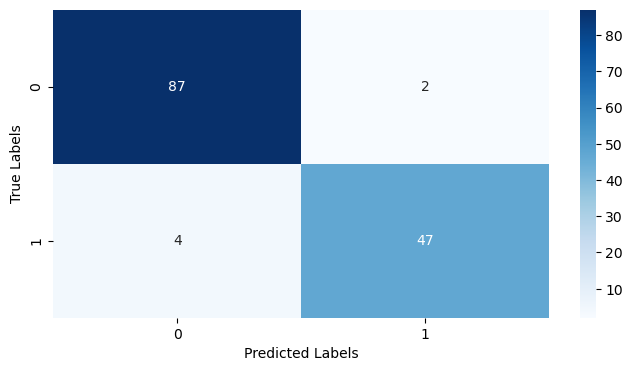

In [110]:
plt.figure(figsize=(8,4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

### **4.6. Classification Report**

In [111]:
# Print Classification Report and Accuracy score (classification accuracy)
#---------------------------------------------------------------------------
y_pred = rfc.predict(X_test)

print("-"*70)
print("Classification Report: \n", classification_report(y_test, y_pred))

print("-"*70)
print("Classification Accuracy on Test Dataset: %0.6f" % metrics.accuracy_score(y_test, y_pred))
print("-"*70)

----------------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        89
           1       0.96      0.92      0.94        51

    accuracy                           0.96       140
   macro avg       0.96      0.95      0.95       140
weighted avg       0.96      0.96      0.96       140

----------------------------------------------------------------------
Classification Accuracy on Test Dataset: 0.957143
----------------------------------------------------------------------


### **4.7. Feature Importance**

In [112]:
X_train.shape

(558, 4)

In [113]:
# The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
# It is also known as the Gini importance.

Feature_Imp = rfc.feature_importances_
Feature_Imp

array([0.21874948, 0.36943974, 0.24037675, 0.17143403])

In [114]:
Feature_Imp.shape

(4,)

In [115]:
Feature_Imp = pd.Series(Feature_Imp,index=X_train.columns).sort_values(ascending=False)
Feature_Imp

SNAP               0.369440
PovertyRate        0.240377
Medfamilyincome    0.218749
TractSNAP          0.171434
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


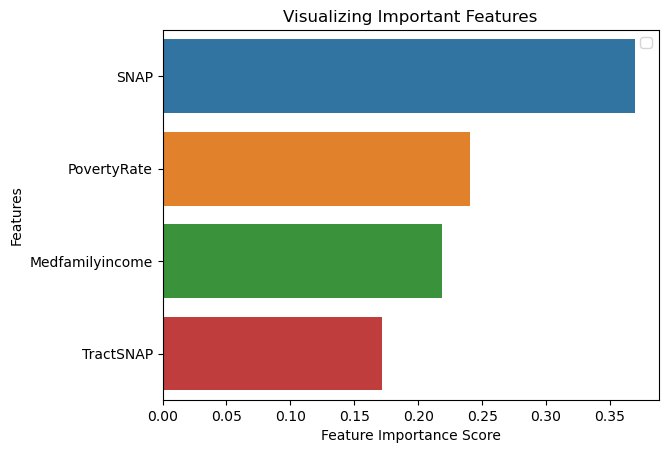

In [116]:
sns.barplot(x=Feature_Imp, y=Feature_Imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### **4.8. Visualize a Decision tree from the model**

https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

sklearn.tree.export_graphviz(decision_tree, out_file=None, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, leaves_parallel=False, impurity=True, node_ids=False, proportion=False, rotate=False, rounded=False, special_characters=False, precision=3, fontname='helvetica')

In [117]:
y_test.value_counts()

0    89
1    51
Name: TargetLabel, dtype: int64

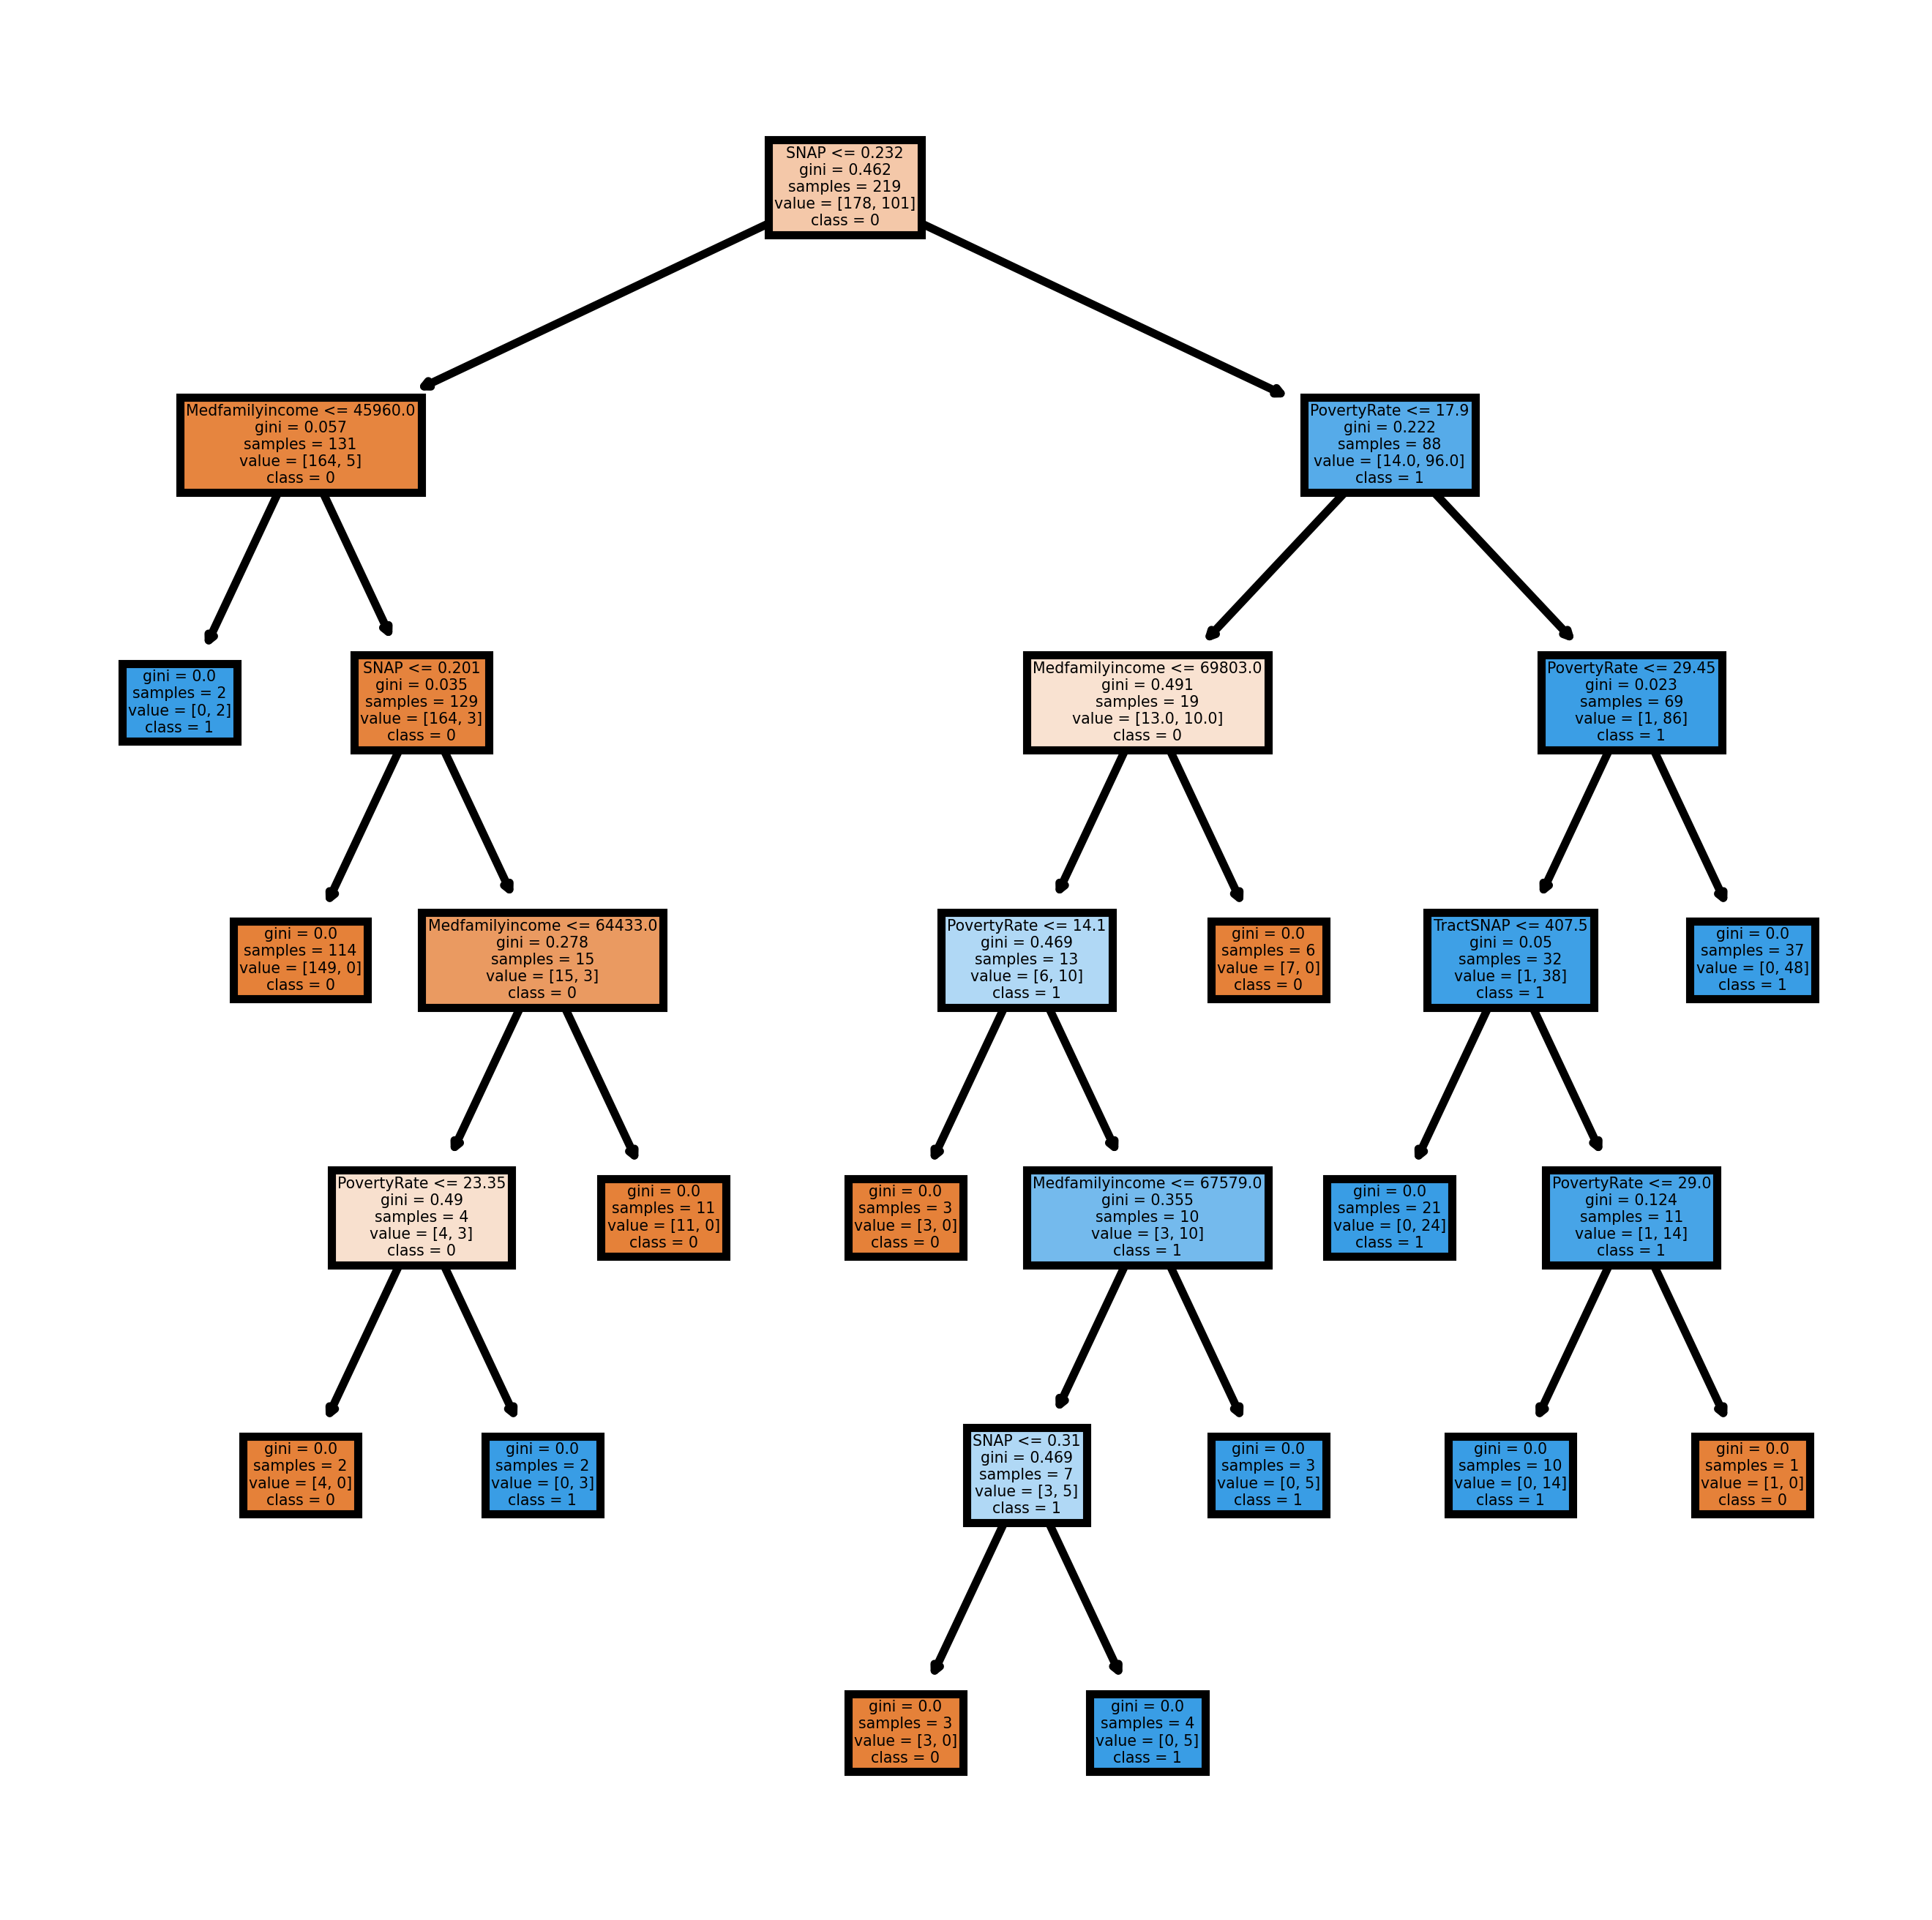

In [118]:
# Plot single decision tree from random forest 

f_names = list(X_train.columns)
c_names = ['0','1','2','3','4']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rfc.estimators_[0],
               feature_names = f_names, 
               class_names= c_names,
               filled = True);

fig.savefig('rf_individualtree.png')

# **Note : Since in the model training, maximum depth parameter is set as None ('max_depth=None'), 
# hence nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

## **5. Save the Trained model**

In [119]:
# Save the trained ML model 
filename = 'FoodDesert_Classification_Iteration2_ML_Model_1.pkl'
pickle.dump(rfc, open(filename, 'wb'))

In [120]:
# loading the saved model
model = pickle.load(open('FoodDesert_Classification_Iteration2_ML_Model_1.pkl', 'rb'))

## **6. Prediction**

In [169]:
X.head()

,Medfamilyincome,SNAP,PovertyRate,TractSNAP
0,87500,0.276615,21.6,278
1,87813,0.178423,15.6,178
2,161250,0.049125,12.4,183
3,52750,0.223124,13.4,283
4,24956,0.475323,46.8,756


In [170]:
X.shape, y.shape

((698, 4), (698,))

In [171]:
y_pred_full = rfc.predict(X)
y_pred_full[:10]

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 1], dtype=int64)

In [172]:
y_pred_full.shape

(698,)

In [173]:
metrics.accuracy_score(y, y_pred_full)

0.9899713467048711

In [174]:
y_pred_full = pd.Series(data=y_pred_full)

In [176]:
y_pred_full.head()

0    1
1    0
2    0
3    0
4    1
dtype: int64

In [183]:
data_actual_vs_predict = pd.concat([TRACTCE,X,y], axis=1)
data_actual_vs_predict.head()

,TRACTCE,Medfamilyincome,SNAP,PovertyRate,TractSNAP,TargetLabel
0,57800,87500,0.276615,21.6,278,1
1,37000,87813,0.178423,15.6,178,0
2,19900,161250,0.049125,12.4,183,0
3,40000,52750,0.223124,13.4,283,0
4,98200,24956,0.475323,46.8,756,1


In [184]:
data_actual_vs_predict['Predicted_Label'] = y_pred_full

In [186]:
data_actual_vs_predict.to_csv('Dataset_with_Prediction.csv')   # for reference

In [187]:
data_actual_vs_predict.head()

,TRACTCE,Medfamilyincome,SNAP,PovertyRate,TractSNAP,TargetLabel,Predicted_Label
0,57800,87500,0.276615,21.6,278,1,1
1,37000,87813,0.178423,15.6,178,0,0
2,19900,161250,0.049125,12.4,183,0,0
3,40000,52750,0.223124,13.4,283,0,0
4,98200,24956,0.475323,46.8,756,1,1


In [121]:
X_train.head(3)

,Medfamilyincome,SNAP,PovertyRate,TractSNAP
241,80625,0.222222,18.1,95
208,48750,0.384328,35.1,438
610,83894,0.158562,13.6,70


In [122]:
y_train.head()

241    0
208    1
610    0
617    1
573    0
Name: TargetLabel, dtype: int64

In [123]:
X_test.head(3)

,Medfamilyincome,SNAP,PovertyRate,TractSNAP
1,87813,0.178423,15.6,178
186,60625,0.483740,23.3,635
417,56223,0.221841,31.2,251


In [124]:
y_test.head()

1      0
186    1
417    1
78     1
537    0
Name: TargetLabel, dtype: int64

In [125]:
X_test.shape

(140, 4)

In [126]:
# predicting for random sample from train or test data (this is temporary, and will be removed before deploying the model)

sample_no = 60

predict_sample  = X_test.iloc[sample_no].to_numpy()
predict_sample

array([1.0056800e+05, 6.3664593e-02, 8.1000000e+00, 3.1000000e+01])

In [127]:
X_test.iloc[sample_no]

Medfamilyincome    100568.000000
SNAP                    0.063665
PovertyRate             8.100000
TractSNAP              31.000000
Name: 146, dtype: float64

In [128]:
y_test.iloc[sample_no]

0

In [129]:
input_data = predict_sample

# changing the input_data to numpy array
input_data = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data = input_data.reshape(1,-1)

print('-'*50)
predict_label = model.predict(input_data)   # prediction
print("Predicted Label : ", predict_label[0])
print("Actual Label    : ", y_test.iloc[sample_no])

print('-'*50)
if (predict_label[0] == 0):
  print('Not a Food Desert')
else :
  print('Food Desert')

print('-'*50)

--------------------------------------------------
Predicted Label :  0
Actual Label    :  0
--------------------------------------------------
Not a Food Desert
--------------------------------------------------


C:\Users\Srinivas\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## **Observations**

* K-Means Clustering (**yet to finalize the appropriate clustering algorithm for this dataset**):
     * Training data has been standardized with StandardScaler
     * One food desert and one non-food desert data point are used as initial cluster seeds.
     * Algorithm has labelled the high poverty rate census tracts in to one class, and the remaining in to other class.
     * Labels obtained from clustering are : **0- not a food desert, 1-food desert**

* Classification model (**Random Forest**) :
  * classification model accuracy :  training dataset = 99% and testing dataset = 96%.
  